# Simulating data from the Ricker Model

We have a process model with complicated behaviour that we extended to versions from which simulate any kind of data:
- Chaotic or non-chaotic
- single-species or multi-species
- dependent on exogeneous factors (Temperature only) or not
- deterministic or stochastic (that refers to fully observable or with observation error, currently)

We now want a simulator object, that let's us make choices on the model and then on the way of simulation.

In [2]:
import simulations
import matplotlib.pyplot as plt
import numpy as np

import utils

SIMULATION UNDER THE FOLLOWING CONDITIONS:
Type of Ricker Model that will be used:    single-species
Simulation from Ricker in the following regime:   non-chaotic
Exogeneous impact on state variable considered?    exogeneous
UNCERTAINTIES CONSIDERED:
Consider parameter uncertainty:       False
Consider initial condition uncertainty:       True
Consider process uncertainty, i.e. NOT deterministic:     True


/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/models.py:152: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


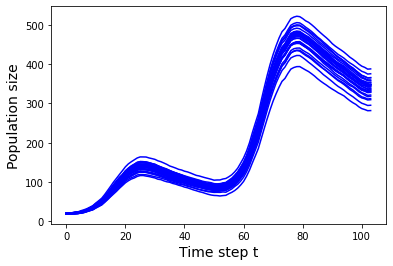

In [3]:
# create simulator object
sims = simulations.Simulator(model_type="single-species",
                             simulation_regime="non-chaotic",
                             environment="exogeneous")
# Set hyperparameters. We'll simulate on a weekly resolution. Years is changed to weeks.
sims.hyper_parameters(simulated_years=2,
                           ensemble_size=30,
                           initial_size=20)
x = sims.simulate()
x_base = x.copy()

Let's explore the data we simulated quantitatively and visually.



(30, 104)


/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_17212/320075238.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


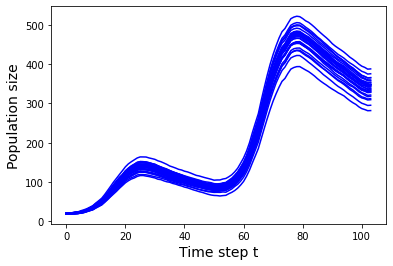

In [4]:
print(x.shape)


## Density estimation and cumulative probability

Some data will not fit nicely in any known probability distribution. Sometime, however, we need a probability density function for our data - for example if we want to compute a measure of predictability based on the climatological distribution. In a perfect model scenario, that is the distribution at a current time $t$, simulated from the model that has been initialized in an approx. infinite past $t-n$ with all uncertainties **fully** propagated up to $t$.
This is obviously not the case here, but considering we're in a perfect model framework, through many simulations we propagate the uncertainty:
- initial condition uncertainty through simulating ensembles
- model uncertainty through observation error
- exogenous variable uncertainty we currently neglect.
- parameter uncertainty we currently neglect.
We plot the whole simulated data set and see, that this might be an unknown distribution

/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_41805/3182759623.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


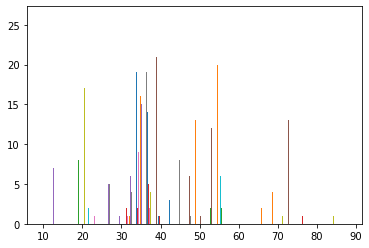

In [14]:
fig = plt.figure()
ax = fig.add_subplot()
plt.hist(x, bins=30)
fig.show()

/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_41805/24782828.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


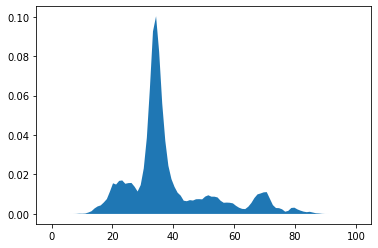

In [15]:
# Just this histogram is not very helpful: It shows the total height at each location, but it would be nice to have it smooth. This is what Kernel density estimation is used for (https://scikit-learn.org/stable/modules/density.html).
from sklearn.neighbors import KernelDensity

x_values = np.linspace(0,100, 100)[:, np.newaxis]
x_new = np.concatenate(x)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(x_new) # the higher the bandwidth the smoother
log_dens = kde.score_samples(x_values)

fig = plt.figure()
ax = fig.add_subplot()
ax.fill(x_values, np.exp(log_dens))
fig.show()

An empirical cumulative distributions functions orders the values and assigns probabilities. It's usually estimated with some kernel density estimator. In python, we can fit the function ecdf in the statsmodel package to get the ecdf of our data. It displays the probability that a random variable $X$ will take a values less or equal to x.
$F_X(x) = P(X \leq x)$.

/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_41805/1077951179.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


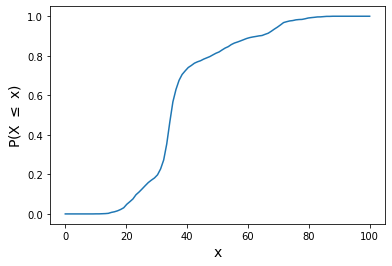

In [16]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(x.flatten())
x_probs = ecdf(x_values)

fig = plt.figure()
ax = fig.add_subplot()
plt.plot(x_values, x_probs)
#plt.plot(ecdf.x, ecdf.y)
ax.set_xlabel('x', size=14)
ax.set_ylabel('P(X $\leq$ x)', size=14)
fig.show()
#ecdf.y

# Structured sampling

## Group-specific parameters with homogeneous variance.

(5, 30, 104)


/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_41805/2764779258.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


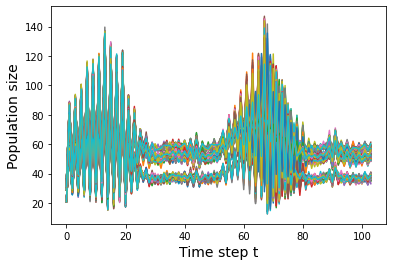

In [17]:
# Let's do the same simulation but with structured sampling: We sample multiple populations with slightly different true parameter values.
x = np.array(sims.simulate(structured_samples=5))
print(x.shape)

fig = plt.figure()
ax = fig.add_subplot()
for i in range(x.shape[0]):
    plt.plot(np.transpose(x[i,:,:]))
ax.set_xlabel('Time step t', size=14)
ax.set_ylabel('Population size', size=14)
fig.show()

## Group-specific parameters with heterogeneous variance.

What variance exactly is heterogeneous here?


# Splitting the data

In machine learning it's common to split the data into three chunks: A training set, a validation set and a test set. We can summarize the training and validation set, as we will pursue the training procedure in a cross-validation anyways. This is done to prevent overfitting. The test set will be held out and used for validation only.
Equivalently for forecasting: We have a long series of historical data, that our model and parameters are based on. For the time period we want to forecast, there are no observations available in the real world. In the simulation setting, however, we can of course evaluate the forecast.
As such, this section will be dedicated to data splitting for both use cases.

## Splitting data for forecasting with the Ricker

In the perfect model framework, we assume
- no parameter uncertainty
- no model structural uncertainty
- a fully known analyses distribution

/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/utils.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_41805/4172301643.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(30, 260)


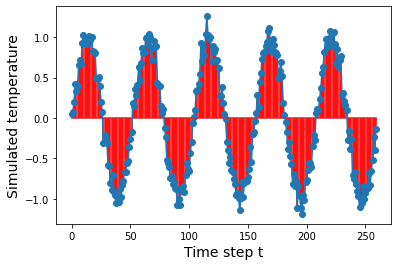

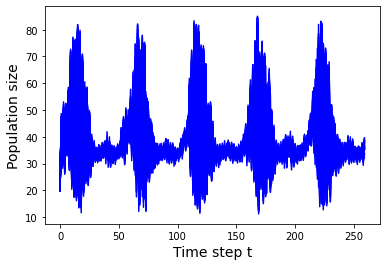

In [22]:
# create simulator object
sims = simulations.Simulator()
# Set hyperparameters. We'll simulate on a weekly resolution. Years is changed to weeks.
sims.hyper_parameters(simulated_years=5,
                           ensemble_size=30,
                           initial_size=20)
sims.simulation_parameters(regime="non-chaotic", behaviour="stochastic")
sims.environment('exogeneous', trend=True)
sims.model_type("single-species")
x = sims.simulate()
print(x.shape)

fig = plt.figure()
ax = fig.add_subplot()
plt.plot(np.transpose(x), color="blue")
ax.set_xlabel('Time step t', size=14)
ax.set_ylabel('Population size', size=14)
fig.show()

Now let's cut this off to a random time step $t=180$, from which on, we assume no observations available anymore.
We don't have to care about the parameters. We have a distribution at this point of **all X** , as well as of the last days only.



In [26]:
def split_data(x, t = 180):
    x_train, x_test = x[:,:t], x[:,t:]
    return x_train, x_test

x_train, x_test = split_data(x)
print(x_train.shape, x_test.shape)
# What are the moments of the current distribution?
print(np.mean(x_train[:,-1]), np.std(x_train[:,-1]))

(30, 180) (30, 80)
23.345798232992347 6.192014915868258


## Splitting data for Machine Learning Analyses


# Detecting chaotic behaviour

The Lyapunov exponent is a property of a function that gives information on the function regime, if it is chaotic or non-chaotic. We can compute it from the first derivative of the model.
For the Single-Species Ricker without temperature dependence, our knowledge of high-school calculus might be sufficient to find the derivative in closed form. However, if we pick one of the more complex models, we will get to our precision limits. So let's use the torch.autograd package to find the numerical derivative (based on: autograd_grad_griesler.jpynb).

In [5]:
import torch
from torch.autograd import grad

At the example of the Single-species model we just specified, let's the define the function we want to derive.
$N_{t+1} = \lambda * N * e^{-\alpha N}$. From theory we know that the regime depends on the parameter $\lambda$ that represents the exponential of the growth rate and that is defined as $\lambda = e^{r}$. $\alpha$ is the inverse of the carrying capacity, as such $\alpha = 1/k$.
First, the model parameters that were used for the above simulation we choose manually. Those are:
$r = 1.9$
$k = 20$


In [19]:
def f(N, r= 1.9, k=20):
    return torch.exp(torch.tensor(r)) * N * torch.exp(- 1/k * N)

The points that we want to take the derivative at, we just simulated. Let's use only one ensemble member for now.
Two things are here to note: We can use grad only to if $f(N)$ returns a scalar (in form of a tensor), and if every variable is contained in the graph. That means, we have to calculate the derivative of the vector stepwise for every element.



In [20]:
def lyapunov(x):
    '''
    Calculate the Lyapunov exponent of the function f(N) that has been evolved for a known N_start.
    '''
    df_dN = []
    for i in range(x.shape[1]): # stepwise derivative
        N = x[:, i]
        N = torch.tensor(N, requires_grad=True) # set requires_grad = True for computing the gradient
        dN = grad(f(N), N)
        df_dN.append(torch.tensor(dN)) # turn tuple into tensor
    df_dN = torch.cat(df_dN).detach().numpy()

    return np.mean(np.log(abs(df_dN)))

xs = x_base[np.random.choice(np.arange(x_base.shape[0]), 1), :] # pick a random ensemble member
print(lyapunov(xs))

-0.4453809616486877


SIMULATION UNDER THE FOLLOWING CONDITIONS:
Type of Ricker Model that will be used:    single-species
Simulation from Ricker in the following regime:   non-chaotic
Exogeneous impact on state variable considered?    non-exogeneous
UNCERTAINTIES CONSIDERED:
Consider parameter uncertainty:       False
Consider initial condition uncertainty:       True
Consider process uncertainty, i.e. NOT deterministic:     True


/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/models.py:152: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


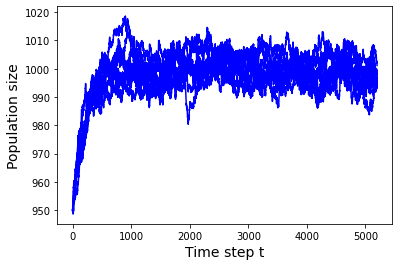

# Using scipy integration.

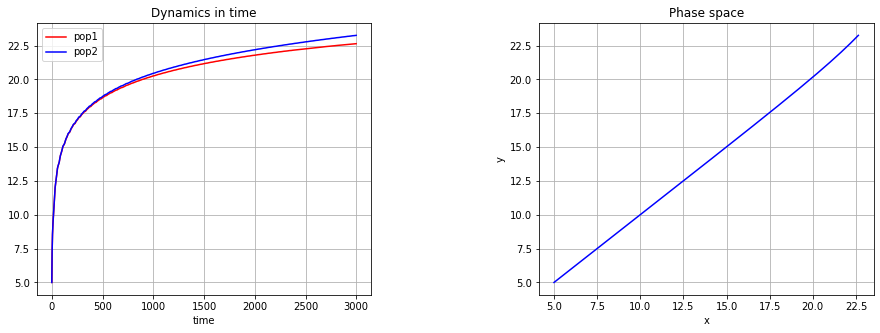

In [91]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import utils



def lambda_x(t):
    ind = int(t)
    return 0.7 + 0.03 * T[ind] + 0.1 * T[ind]**2

def lambda_y(t):
    ind = int(t)
    return 0.7 + 0.03 * T[ind] + 0.1 * T[ind]**2

def sys(X, t, lambda_x, lambda_y):

    #define system as array

    Nx =  X[0] * np.exp(lambda_x(t)*(1- 1/20*X[0] - 0.60002*X[1]))
    Ny = X[1] * np.exp(lambda_y(t)*(1 - 1/20*X[1] - 0.60001*X[0]))

    return np.array([Nx, Ny])

timesteps = 3000
t = np.linspace(1,timesteps, timesteps)
T = utils.simulate_T(timesteps*5,show=False)
X_in = [5, 5]

args = (lambda_x, lambda_y)
X, infodict = integrate.odeint(sys, X_in, t, args, full_output=True)

x,y = X.T

#plot
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(wspace = 0.5, hspace = 0.3)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(x, 'r-', label='pop1')
ax1.plot(y, 'b-', label='pop2')
ax1.set_title("Dynamics in time")
ax1.set_xlabel("time")
ax1.grid()
ax1.legend(loc='best')

ax2.plot(x, y, color="blue")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Phase space")
ax2.grid()